# Deep learning tests

## Load libraries and data

In [1]:
import scipy.io as scio
from scipy.interpolate import CubicSpline
import numpy as np 
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.linear_model
import torch
import torch.nn
import torch.nn.functional
import torch.utils.data
import tqdm
data = scio.loadmat('../Data/tissue3_1.mat')
calibration = scio.loadmat('../Data/cal_14.mat')

In [2]:
import blosc
import pickle
def decompress(file,prealloc_arr=None):
    f=open(file,"rb")
    shape,arr_size,dtype,is_f_contiguous,num_chunks,max_num=pickle.load(f)

    if prealloc_arr is None:
        arr=np.empty(arr_size,dtype)
    else:
        arr=np.frombuffer(prealloc_arr.data, dtype=dtype, count=arr_size)

    for i in range(num_chunks):
        size=np.fromfile(f,np.uint32,count=1)
        c=f.read(size[0])
        blosc.decompress_ptr(c, arr[max_num*i:].__array_interface__['data'][0])
    f.close()

    #reshape
    if is_f_contiguous:
        arr=arr.reshape(shape[::-1]).T
    else:
        arr=arr.reshape(shape)
    return arr

In [ ]:
# Look at imported data
for key, value in data.items():
    try:
        print(key, value.shape)
    except:
        print(key, len(value))

In [7]:
target = data['IDX']
tissue_data = data['map_t3'] 
no_baseline = decompress('../Preprocessed/t3_1.lz4')

## Simplify data 

In [13]:
target_simple = target.copy()
for i in range(200):
    for j in range(200):
        if target[i,j] == 4:
            target_simple[i,j]=1
        if target[i,j] == 5:
            target_simple[i,j]=2
        if target[i,j] == 8:
            target_simple[i,j]=3
        if target[i,j] == 10:
            target_simple[i,j]=4

In [25]:
for i in range(200):
    for j in range(200):
        target[i,j] = target[i,j]-1
myset = set(target.flatten()) 
print(myset)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14}


In [6]:
fake_data = tissue_data.copy()
import random 
p = 0.9

for i in range(200):
    for j in range(200):
        this_spectra = np.zeros(1024)

        for k in range(128):
            if random.random() < p:
                this_spectra[k] = target_simple[i,j]
            else:
                this_spectra[k] = random.randint(0,5)
        
        fake_data[i,j,:] = this_spectra

## Convolutional neural network

In [26]:
X = []
for i in range(200):
    for j in range(200):
        X.append(no_baseline[i,j,:])
        
y = []
for i in range(200):
    for j in range(200):
        y.append(target[i,j])

In [27]:
X_train, X_test, y_train, y_test = sklearn.model_selection.train_test_split(X, y, test_size=.2, shuffle=False)

scaler = sklearn.preprocessing.StandardScaler()

X_train = scaler.fit_transform(X_train)
X_train = X_train.reshape(32000,1,-1)
X_test = scaler.transform(X_test)
X_test = X_test.reshape(8000,1,-1)

In [18]:
class ConvolutionalNeuralNetwork(torch.nn.Module):
    def __init__(self):
        super(ConvolutionalNeuralNetwork, self).__init__()
        self.conv1 = torch.nn.Conv1d(1,10,kernel_size=3,padding='same')      # out: [batch, 5, 128]
        self.relu1 = torch.nn.ReLU()                                        # out: [batch, 5, 128]
        self.pool1 = torch.nn.AvgPool1d(3, stride=2, padding=1)             # out: [batch, 5, 64]  
        self.conv2 = torch.nn.Conv1d(10,20,kernel_size=3,padding='same')     # out: [batch, 10, 64]

        self.flat = torch.nn.Flatten()                                      # out: [batch, 640]
        self.drop = torch.nn.Dropout(p=0.2)

        self.fc1 = torch.nn.Linear(10240, 50)
        self.relu2 = torch.nn.ReLU()
        self.fc2 = torch.nn.Linear(50, 15)
        self.softmax = torch.nn.Softmax(dim=1)
    
    def forward(self, x):
        output = self.conv1(x)
        output = self.relu1(output)
        output = self.pool1(output)
        output = self.conv2(output)
    
        output = self.flat(output)
        output = self.drop(output) 

        output = self.fc1(output)
        output = self.relu2(output)
        output = self.fc2(output)
        output = self.softmax(output)
        return output

In [28]:
model = ConvolutionalNeuralNetwork()

tensor_X_train = torch.Tensor(X_train)
tensor_y_train = torch.Tensor(y_train).long()

dataset = torch.utils.data.TensorDataset(tensor_X_train, tensor_y_train)

data_loader = torch.utils.data.DataLoader(dataset, batch_size=None,
        sampler=torch.utils.data.BatchSampler(torch.utils.data.RandomSampler(dataset), batch_size=30000, drop_last=False))

criterion = torch.nn.CrossEntropyLoss() 

learning_rate = 0.1
num_epochs = 50

optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)

model.train();

In [29]:
loss_history = []
accuracy_history = []
for epoch in tqdm.trange(num_epochs):
    for i, (inputs, targets) in enumerate(data_loader):
        optimizer.zero_grad()
        y_pred = model(inputs)
        loss = criterion(y_pred, targets)
        loss.backward()
        optimizer.step()
        loss_history.append(loss.item())
        #correct = (torch.argmax(y_pred, dim=1) == targets).type(torch.FloatTensor)
        #accuracy_history.append(correct.mean())

100%|██████████| 50/50 [15:56:10<00:00, 1147.41s/it]   


Text(0, 0.5, 'loss')

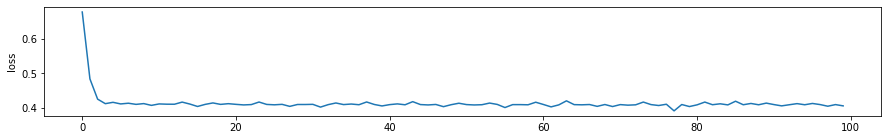

In [27]:
plt.figure(figsize=(15,2))
plt.plot(loss_history)
plt.ylabel('loss')

### Let's see how the model does...

In [30]:
model.eval();

In [31]:
tensor_X_test = torch.Tensor(X_test)
tensor_y_test = torch.Tensor(y_test).long()

y_pred_train = model(tensor_X_train) # 32000
y_pred_test = model(tensor_X_test)   #  8000

In [32]:
results = []

for item in y_pred_train:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)

for item in y_pred_test:
    array = item.detach().numpy()
    index = np.argmax(array)
    results.append(index)
    
approximation = np.zeros((200,200))
for i in range(200):
    for j in range(200):
        index = i*200 + j
        approximation[i,j] = results[index]

Text(0.5, 0, 'x [a.u.]')

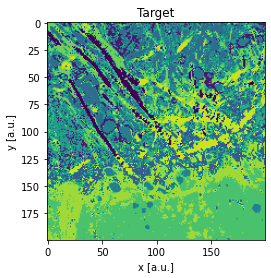

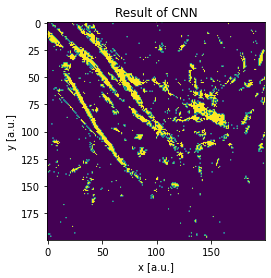

In [33]:
plt.figure()
plt.imshow(target)
plt.title('Target')
plt.ylabel('y [a.u.]')
plt.xlabel('x [a.u.]')

plt.figure()
plt.imshow(approximation)
plt.title('Result of CNN')
plt.ylabel('y [a.u.]')
plt.xlabel('x [a.u.]')